# <font color='green'>**Libraries, Functions and Random Seeds**</font>


In [ ]:
import numpy as np
import tensorflow as tf
import keras

import random

from keras import Sequential
from keras.layers import Input, Dense, LSTM, GRU, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from scipy.stats import beta
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from google.colab import files, drive

In [ ]:
seed_value = 42

# python
random.seed(seed_value)
# numpy
np.random.seed(seed_value)
# tensorflow
tf.random.set_seed(seed_value)

In [ ]:
# Uncomment when importing from GitHub
!git clone https://www.github.com/MorgilloR/time-varying-channels.git
%cd /content/time-varying-channels
dir = '/content/time-varying-channels'

# Uncomment when importing from Google Drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/'Colab Notebooks'/time-varying-channels/
#dir = '/content/drive/MyDrive/"Colab Notebooks"/time-varying-channels'

sys.path.append(dir)
from tvc import *

Cloning into 'time-varying-channels'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 7.93 KiB | 7.93 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/time-varying-channels


# <font color='red'>**Forecasting**</font>

In [ ]:
def deterministic1(a, b, length, i):
    eta_ks = []
    Delta = np.random.uniform(Delta_exp_min, Delta_exp_max)
    for k in range(length):
        eta = exp_eta(a, b, k, Delta)
        eta_ks.append(eta)
    return eta_ks, Delta

In [ ]:
def deterministic2(a, b, length, i):
    eta_ks = []
    Delta = np.random.uniform(Delta_cos_min, Delta_cos_max)
    for k in range(length):
        eta = cos_eta(a, b, k, Delta)
        eta_ks.append(eta)
    return eta_ks, Delta

In [ ]:
# Parameters
n_training = 100000  # number of data samples
n_test = 10000
r = 1  # squeezing parameter
input_steps = 15  # number of input steps
output_steps = 3  # number of output steps
a_min, a_max = 0, 0.5  # Range for a
b_min, b_max = 0, 0.5  # Range for b
Delta_exp_min, Delta_exp_max = 10, 30
Delta_cos_min, Delta_cos_max = 1, 10

input_training_data = []
input_test_data = []
output_training_data = []
output_test_data = []

# Calculate sequence_length here
sequence_length = input_steps + output_steps  # total sequence length (input + output)

for i in range(n_training):  # Iterate through all samples
        a = np.random.uniform(a_min, a_max)
        b = np.random.uniform(b_min, b_max)
        eta_sequence, Delta = deterministic1(a, b, sequence_length, i)

        # Prepare input and output sequences
        eta_sequence = np.array(eta_sequence)
        input_sequence = eta_sequence[:input_steps]  # First 6 steps as input
        output_sequence = eta_sequence[input_steps:]  # Last 3 steps as output

        # Create covariance matrix for input data
        cov_matrix = diag_cov_matrix(input_sequence, r)

        # Append input and output sequences to the respective lists
        input_training_data.append(cov_matrix)
        output_training_data.append(output_sequence)

# Convert the lists to numpy arrays
X_train = np.array(input_training_data)
y_train = np.array(output_training_data)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# Shuffle X_train and y_train together
X_train, y_train = shuffle(X_train, y_train, random_state=42)

a_test = []
b_test = []
Delta_test = []
for i in range(n_test):  # Iterate through all samples
        a = np.random.uniform(a_min, a_max)
        b = np.random.uniform(b_min, b_max)
        eta_sequence, Delta = deterministic1(a, b, sequence_length, i)

        # Prepare input and output sequences
        eta_sequence = np.array(eta_sequence)
        input_sequence = eta_sequence[:input_steps]
        output_sequence = eta_sequence[input_steps:]

        # Create covariance matrix for input data
        cov_matrix = diag_cov_matrix(input_sequence, r)

        # Append input and output sequences to the respective lists
        input_test_data.append(cov_matrix)
        output_test_data.append(output_sequence)
        a_test.append(a)
        b_test.append(b)
        Delta_test.append(Delta)

# Convert the lists to numpy arrays
X_test = np.array(input_test_data)
y_test = np.array(output_test_data)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Initialize the model
optimizer = Adam(learning_rate=0.0005)
model = Sequential()
model.add(Input(shape=(input_steps, 1)))
#model.add(GRU(32, activation='relu'))
model.add(tf.keras.layers.Flatten())
#model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(output_steps))
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with the custom callback
history = model.fit(X_train, y_train, epochs=500, batch_size=1000, validation_data=(X_test, y_test))

Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0168 - val_loss: 0.0044
Epoch 2/500
 79/100 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034

KeyboardInterrupt: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

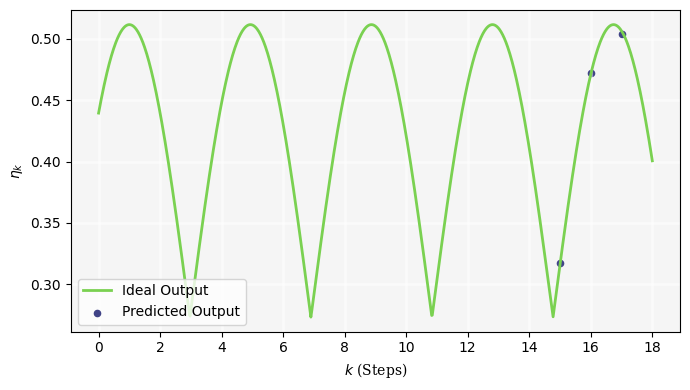

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

idx = 45

plt.figure(figsize=(7, 4))
# Define the viridis colormap
cmap = plt.cm.viridis

predicted_output = y_pred[idx]

k_values = np.linspace(0, sequence_length, 1000)
a= a_test[idx]
b = b_test[idx]
Delta = Delta_test[idx]

if idx % 2 == 0:
  y_values = exp_eta(a, b, k_values, Delta)
else:
  y_values = cos_eta(a, b, k_values, Delta)

# Plot ideal output
plt.plot(k_values, y_values, label="Ideal Output", color=cmap(0.8), linewidth=2)

# Plot predicted output
plt.scatter(np.arange(input_steps, input_steps + output_steps), predicted_output,
            label="Predicted Output", marker='o', color=cmap(0.2), s=20)
plt.grid(True, linestyle='-', alpha=0.5, color='white', lw=2)

plt.gca().set_facecolor('#F5F5F5')

# Add titles and labels
plt.xlabel(r"$k$ (Steps)", family='serif')
plt.ylabel(r"$\eta_k$", family='serif')
#plt.ylim(0.1, 1)
plt.xticks(np.arange(0, sequence_length + 1, 2))
plt.legend()

# Show the plot
plt.tight_layout()
#plt.show()

plt.savefig("fcos1.pdf",\
            bbox_inches='tight', pad_inches=0.25, format="pdf")
files.download("fcos1.pdf")

# <font color='purple'>**Other tests**</font>

### <font color='purple'>**Bins**</font>

In [ ]:
# Parameters
sequence_length = 10
dataset_size = 8000
n_bins = 2  # Number of bins for mu
r = 1
samples_per_bin = dataset_size // n_bins  # Ensure equal distribution

# Initialize input (X) and output (y)
X_0 = np.zeros((dataset_size, sequence_length))
y_0 = np.zeros(dataset_size)  # Labels for bins

# Generate a random eta_bar and sigma
alpha = 2
beta = 2
eta_bar = mean_from_alpha_and_beta(alpha, beta)
sigma = variance_from_alpha_and_beta(alpha, beta)
#eta_bar = np.random.uniform(0, 1)
#sigma = np.random.uniform(0, min(eta_bar*(1 - eta_bar)/(1 + 1/eta_bar),
#                                 eta_bar*(1 - eta_bar)/(1 + 1/(1-eta_bar))))

# Define custom bin edges
bin_edges = np.array([0, 0.5, 1])
#bin_edges = np.array([0, 1/4, 1/2, 3/4, 1])
#bin_edges = np.array([0, (1/4)**(1/3), 0.5**(1/3), (3/4)**(1/3), 1])
#bin_edges = np.array([0, (1/5)**(1/3), (2/5)**(1/3), (3/5)**(1/3), (4/5)**(1/3), 1])

# Generate samples ensuring equal class distribution
index = 0
for bin_idx in range(n_bins):
    # Sample mu values uniformly within the bin
    mu_values = np.random.uniform(bin_edges[bin_idx], bin_edges[bin_idx + 1], samples_per_bin)

    for mu in mu_values:
        # Assign label
        y_0[index] = bin_idx

        # Generate eta sequence
        eta_sequence = markovian(eta_bar, sigma, mu, sequence_length)
        X_0[index] = diag_cov_matrix(np.array(eta_sequence), r)

        index += 1

# Reshape X_0
X_0 = X_0[..., np.newaxis]

# Convert labels to categorical format
y_0_categorical = to_categorical(y_0, num_classes=n_bins)

# Shuffle the dataset to mix classes
indices = np.arange(dataset_size)
np.random.shuffle(indices)
X_0, y_0_categorical = X_0[indices], y_0_categorical[indices]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_0, y_0_categorical, test_size=0.2, random_state=42)

# Train a classifier
model = Sequential()
model.add(Input(shape=(sequence_length, 1)))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(n_bins, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.003)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size = 1000, validation_data=(X_test, y_test))

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.4949 - loss: 0.6940 - val_accuracy: 0.4944 - val_loss: 0.6932
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.5007 - loss: 0.6932 - val_accuracy: 0.4944 - val_loss: 0.6933
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - accuracy: 0.4936 - loss: 0.6933 - val_accuracy: 0.4944 - val_loss: 0.6932
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - accuracy: 0.4890 - loss: 0.6933 - val_accuracy: 0.4944 - val_loss: 0.6932
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.4959 - loss: 0.6932 - val_accuracy: 0.5056 - val_loss: 0.6931
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.5080 - loss: 0.6931 - val_accuracy: 0.5056 - val_loss: 0.6931
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.4957 - loss: 0.6931 - val_accuracy: 0.5275 - val_loss: 0.6931
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5012 - loss: 0.6931 - val_accuracy: 0.5350 - v

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

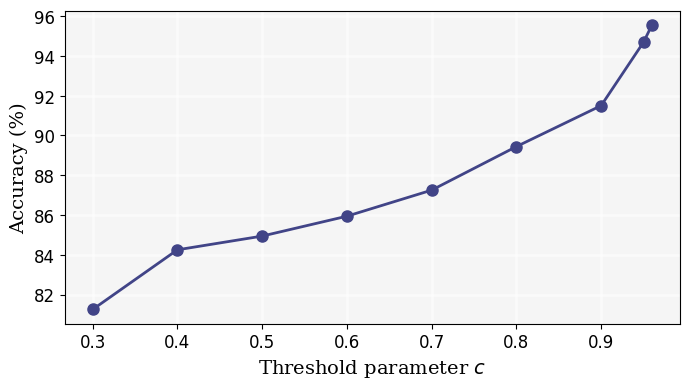

In [ ]:
c = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96]
accs = [81.25, 84.25, 84.94, 85.94, 87.25, 89.44, 91.5, 94.69, 95.56]

# Create the plot
plt.figure(figsize=(7, 4))

# Define the viridis colormap and use a color that stands out
cmap = plt.cm.viridis
plt.plot(c, accs, marker='o', color=cmap(0.2), markersize=8, linestyle='-', linewidth=2)

plt.xlabel(f'Threshold parameter $c$', fontsize=14, family='serif')
plt.ylabel('Accuracy (%)', fontsize=14, family='serif')

# Customize tick labels (keeping the default font for numbers)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Add gridlines (light, dotted)
plt.grid(True, linestyle='-', alpha=0.5, color='white', lw=2)

plt.gca().set_facecolor('#F5F5F5')
# Show the plot
plt.tight_layout()  # Adjust layout to avoid cutting off labels
plt.show()

# Save the plot to a PDF file
#plt.savefig("bins.pdf", bbox_inches='tight', pad_inches=0.25, format="pdf")
# Download the file
#files.download("bins.pdf")

In [ ]:
# Convert y_test to class indices if it's one-hot encoded
y_test_indices = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Count occurrences in each class
unique, counts = np.unique(y_test_indices, return_counts=True)
class_counts = dict(zip(unique, counts))
min_samples = min(class_counts.values())  # Smallest class size
print("Class distribution before balancing:", class_counts)
print("Smallest class size:", min_samples)

Class distribution before balancing: {0: 3936, 1: 4068, 2: 3960, 3: 4036}
Smallest class size: 3936


In [ ]:
# Create balanced test set
X_test_balanced = []
y_test_balanced = []

for label in unique:
    idx = np.where(y_test_indices == label)[0]  # Get indices of this class
    selected_idx = np.random.choice(idx, min_samples, replace=False)  # Randomly sample
    X_test_balanced.append(X_test[selected_idx])
    y_test_balanced.append(y_test[selected_idx])

# Convert lists back to arrays
X_test_balanced = np.vstack(X_test_balanced)
y_test_balanced = np.hstack(y_test_balanced) if len(y_test.shape) == 1 else np.vstack(y_test_balanced)

print("New balanced test set shape:", X_test_balanced.shape, y_test_balanced.shape)

New balanced test set shape: (15744, 20, 1) (15744, 4)


492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy on Test Set: 0.7639100609756098


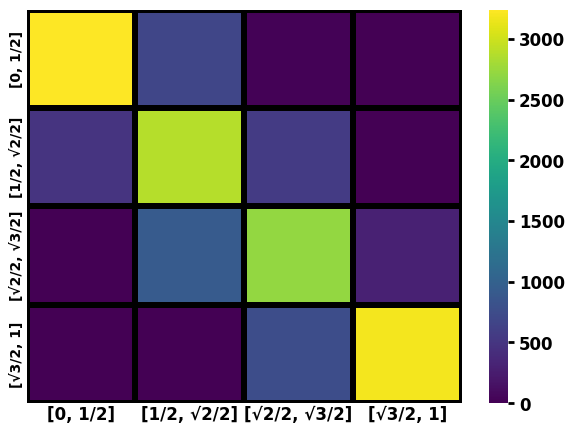

In [ ]:
# Step 1: Predict the labels for the test set
y_pred = np.argmax(model.predict(X_test_balanced), axis=1)
y_true = np.argmax(y_test_balanced, axis=1)

# Step 2: Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
palette = sns.color_palette("viridis", as_cmap=True)

# Define bin labels
bin_labels = ["[0, 1/2]", "[1/2, \u221a2/2]", "[\u221a2/2, \u221a3/2]", "[\u221a3/2, 1]"]

# Plot confusion matrix with enhanced readability
plt.figure(figsize=(6, 4.5))
sns.heatmap(
    cm,
    annot=False,
    fmt="d",
    cmap=palette,
    xticklabels=bin_labels,
    yticklabels=bin_labels,
    annot_kws={"size": 18},  # Increase font size for annotations
    linewidths=3,  # Add grid lines between cells
    linecolor='black',  # Define grid line color
    cbar=True
)

plt.gca().tick_params(axis='both', length=4, width=1, pad=2)  # Reduce tick size and padding
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=10, rotation=90, fontweight='bold')
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=12, width=2, length=4, labelcolor='black')
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()  # Adjust layout to avoid cutting labels
plt.gca().tick_params(axis='both', which='both', length=0)  # Remove all ticks
plt.minorticks_off()  # Disable minor ticks

plt.show()
#plt.savefig("bins1.pdf",\
#            bbox_inches='tight', pad_inches=0.25, format="pdf")
#files.download("bins1.pdf")

# Print evaluation metrics
print("Accuracy on Test Set:", accuracy_score(y_true, y_pred))

### <font color='purple'>**Forecasting for Markovian channels**</font>

In [ ]:
mu_values = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
input_sequence_length = 6
output_sequence_length = 3
dataset_size = 1000
errors = []

for mu in mu_values:
    X = np.zeros((dataset_size, input_sequence_length))
    y = np.zeros((dataset_size, output_sequence_length))

    for i in range(dataset_size):
        alpha = np.random.uniform(1, 2)
        beta = np.random.uniform(1, 2)
        eta_bar = mean_from_alpha_and_beta(alpha, beta)
        sigma = variance_from_alpha_and_beta(alpha, beta)
        eta_sequence = markovian(eta_bar, sigma, mu, input_sequence_length + output_sequence_length)
        X[i] = diag_cov_matrix(np.array(eta_sequence[:input_sequence_length]), r)
        y[i] = eta_sequence[input_sequence_length:]

    X_reshaped = X.reshape((X.shape[0], input_sequence_length, 1))

    # Split dataset into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

    # Initialize the model
    optimizer = Adam(learning_rate=0.001)
    model = Sequential()
    model.add(Input(shape=(input_sequence_length, 1)))
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(output_sequence_length, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model with the custom callback
    history = model.fit(X_train, y_train, epochs=500, batch_size=100, validation_data=(X_test, y_test),
                        verbose=0)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate error (Mean Squared Error)
    error = mean_squared_error(y_test, y_pred)
    errors.append(error)

Epoch 50, Loss: 0.0591
Epoch 100, Loss: 0.0579
Epoch 150, Loss: 0.0571
Epoch 200, Loss: 0.0562
Epoch 250, Loss: 0.0555
Epoch 300, Loss: 0.0551
Epoch 350, Loss: 0.0547
Epoch 400, Loss: 0.0544
Epoch 450, Loss: 0.0541
Epoch 500, Loss: 0.0538
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 50, Loss: 0.0501
Epoch 100, Loss: 0.0492
Epoch 150, Loss: 0.0489
Epoch 200, Loss: 0.0487
Epoch 250, Loss: 0.0486
Epoch 300, Loss: 0.0484
Epoch 350, Loss: 0.0483
Epoch 400, Loss: 0.0481
Epoch 450, Loss: 0.0480
Epoch 500, Loss: 0.0478
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 50, Loss: 0.0387
Epoch 100, Loss: 0.0378
Epoch 150, Loss: 0.0374
Epoch 200, Loss: 0.0371
Epoch 250, Loss: 0.0368
Epoch 300, Loss: 0.0366
Epoch 350, Loss: 0.0363
Epoch 400, Loss: 0.0361
Epoch 450, Loss: 0.0358


Epoch 500, Loss: 0.0356
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 50, Loss: 0.0284
Epoch 100, Loss: 0.0276
Epoch 150, Loss: 0.0274
Epoch 200, Loss: 0.0272
Epoch 250, Loss: 0.0271
Epoch 300, Loss: 0.0270
Epoch 350, Loss: 0.0270
Epoch 400, Loss: 0.0269
Epoch 450, Loss: 0.0269


Epoch 500, Loss: 0.0268
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 50, Loss: 0.0123
Epoch 100, Loss: 0.0117
Epoch 150, Loss: 0.0114
Epoch 200, Loss: 0.0113
Epoch 250, Loss: 0.0113
Epoch 300, Loss: 0.0112
Epoch 350, Loss: 0.0112
Epoch 400, Loss: 0.0112
Epoch 450, Loss: 0.0112
Epoch 500, Loss: 0.0112
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 50, Loss: 0.0175
Epoch 100, Loss: 0.0137
Epoch 150, Loss: 0.0107
Epoch 200, Loss: 0.0086
Epoch 250, Loss: 0.0075
Epoch 300, Loss: 0.0070
Epoch 350, Loss: 0.0067
Epoch 400, Loss: 0.0065
Epoch 450, Loss: 0.0063
Epoch 500, Loss: 0.0062
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 50, Loss: 0.0056
Epoch 100, Loss: 0.0017
Epoch 150, Loss: 0.0015
Epoch 200, Loss: 0.0014
Epoch 250, Loss: 0.0014
Epoch 300, Loss: 0.0013
Epoch 350, Loss: 0.0013
Epoch 400, Loss: 0.0013
Epoch 450, Loss: 0.0013
Epoch 500, Loss: 0.0013
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

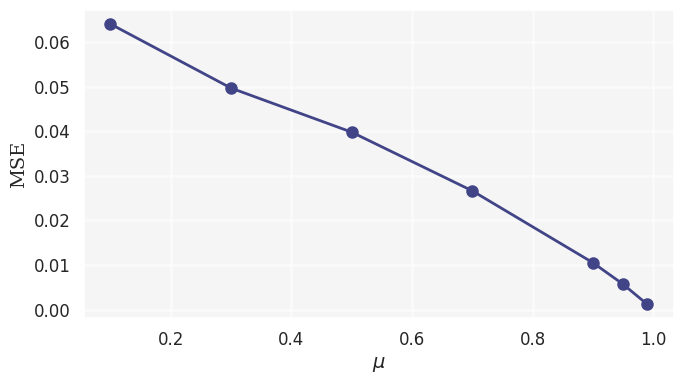

In [ ]:
# Create the plot
plt.figure(figsize=(7, 4))

# Define the viridis colormap and use a color that stands out
cmap = plt.cm.viridis
plt.plot(mu_values, errors, marker='o', color=cmap(0.2), markersize=8, linestyle='-', linewidth=2)

plt.xlabel(r'$\mu$', fontsize=14, family='serif')  # Use serif font for x-axis label
plt.ylabel('MSE', fontsize=14, family='serif')  # Use serif font for y-axis label

# Customize tick labels (keeping the default font for numbers)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Add gridlines (light, dotted)
plt.grid(True, linestyle='-', alpha=0.5, color='white', lw=2)

plt.gca().set_facecolor('#F5F5F5')
# Show the plot
plt.tight_layout()  # Adjust layout to avoid cutting off labels
plt.show()

# Save the plot to a PDF file
#plt.savefig("forecasting1.pdf", bbox_inches='tight', pad_inches=0.25, format="pdf")

# Download the file
#files.download("forecasting1.pdf")